In [5]:
# Standard Library Imports
import os
import sys
import math
import time
import random
import pdb
from collections import OrderedDict

# Third-Party Scientific Computing Libraries
import numpy as np
import pandas as pd
from scipy.ndimage import shift
import seaborn as sns
from scipy.stats import norm

# Machine Learning Libraries
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

# Deep Learning Libraries - PyTorch
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, Subset

# Deep Learning Libraries - TensorFlow and Keras
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, Activation, Input

# Data Acquisition and Visualization Libraries
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Image

In [2]:
# custom function for reproducibility
def custom_set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

custom_set_seed(266)


# Load the data
train_data = pd.read_csv('sp_train.csv', index_col='Date')
test_data = pd.read_csv('sp_test.csv', index_col='Date')

stock_names = train_data.columns[:-1]  # Exclude the S&P 500 index column

index_train = train_data.iloc[:, -1].values
# Extract the target variable (S&P 500 index values) for the test set
index_test = test_data.iloc[:, -1].values

# Normalize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_data.iloc[:, :-1])
X_test = scaler.transform(test_data.iloc[:, :-1])

# Create a scaler for the index values only
index_scaler = MinMaxScaler()
index_train_scaled = index_scaler.fit_transform(train_data.iloc[:, -1].values.reshape(-1, 1))


# Network hyperparameters
n_inputs = X_train.shape[1]

# Define model
input_layer = Input(shape=(n_inputs,))

# Encoder Layers
encoded = Dense(128, activation='relu')(input_layer)
# encoded = Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_layer)
encoded = Dense(64, activation='relu')(encoded)
# encoded = Dense(64, activation='relu')(encoded)

# Decoder Layers
decoded = Dense(128, activation='relu')(encoded)
# decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(n_inputs, activation='linear')(decoded)


# Autoencoder Model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(loss='mse', optimizer='adam')

# Training hyperparameters
epochs = 80
batch_size = 64

# Fit the model
history = autoencoder.fit(X_train, X_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          verbose=1)


Epoch 1/80
73/73 [==============================] - 0s 865us/step - loss: 0.0399
Epoch 2/80
73/73 [==============================] - 0s 967us/step - loss: 0.0056
Epoch 3/80
73/73 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 4/80
73/73 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 5/80
73/73 [==============================] - 0s 997us/step - loss: 0.0021
Epoch 6/80
73/73 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 7/80
73/73 [==============================] - 0s 992us/step - loss: 0.0017
Epoch 8/80
73/73 [==============================] - 0s 994us/step - loss: 0.0016
Epoch 9/80
73/73 [==============================] - 0s 1ms/step - loss: 0.0015
Epoch 10/80
73/73 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 11/80
73/73 [==============================] - 0s 984us/step - loss: 0.0013
Epoch 12/80
73/73 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 13/80
73/73 [==================

19/19 [==============================] - 0s 534us/step - loss: 0.1697
Training MSE: 0.00047996
Testing MSE: 0.16972712


Text(0.5, 0, 'Epoch')

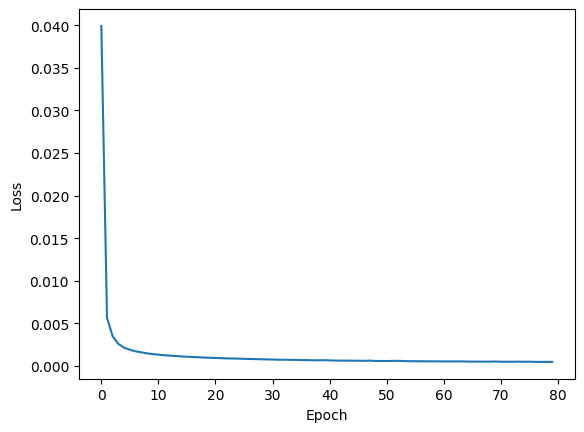

In [3]:
# Evaluate model
score_train = autoencoder.evaluate(X_train, X_train, batch_size=batch_size)
score_test = autoencoder.evaluate(X_test, X_test, batch_size=batch_size)

print('Training MSE: %.8f' %score_train)
print('Testing MSE: %.8f' %score_test)

# Visualize loss history
plt.figure()
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [4]:
# Obtain reconstruction of the stocks
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

# Calculate reconstruction error
error = np.mean(np.abs(X_train - X_train_pred)**2, axis=0)

# Sort stocks by reconstruction error
ind = np.argsort(error)
n = 5  # Number of companies used for index reconstruction

selected_stocks = stock_names[ind[:n]]
print("Selected stocks for the portfolio:", selected_stocks)

portfolio_train = X_train_pred[:, ind[:n]]
portfolio_test = X_test_pred[:, ind[:n]]

# Create portfolio in-sample and out-sample
tracked_index_insample = np.mean(portfolio_train, axis=1)
tracked_index_outofsample = np.mean(portfolio_test, axis=1)

# Reshape your predictions to match the scaler's expected input
tracked_index_insample = index_scaler.inverse_transform(tracked_index_insample.reshape(-1, 1)).flatten()
tracked_index_outofsample = index_scaler.inverse_transform(tracked_index_outofsample.reshape(-1, 1)).flatten()

# Correlation coefficient (in-sample)
corr_train = np.corrcoef(index_train.squeeze(), tracked_index_insample)[0, 1]
print('Correlation coefficient (in-sample): %.8f' %corr_train)

# Correlation coefficient (out-of-sample)
corr_test = np.corrcoef(index_test.squeeze(), tracked_index_outofsample)[0, 1]
print('Correlation coefficient (out-of-sample): %.8f' %corr_test)

37/37 [==============================] - 0s 322us/step
Selected stocks for the portfolio: Index(['ADBE', 'CPRT', 'ODFL', 'FI', 'IEX'], dtype='object')
Correlation coefficient (in-sample): 0.94392913
Correlation coefficient (out-of-sample): 0.99705118


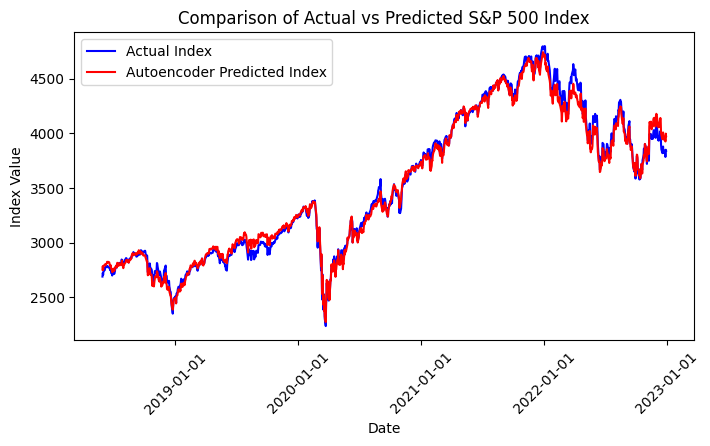

In [6]:
test_data.index = pd.to_datetime(test_data.index)
dates = test_data.index

plt.figure(figsize=(8, 4))
plt.plot(dates, index_test, label='Actual Index', color='blue')
plt.plot(dates, tracked_index_outofsample, label='Autoencoder Predicted Index', color='red')
plt.title('Comparison of Actual vs Predicted S&P 500 Index')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()

# Improve formatting of dates on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)  # Rotate dates for better readability

plt.show()


In [9]:
def evaluate_index_performance(y_test, y_pred, num_companies_used, total_companies=360):
    # Calculate RMSE and normalized RMSE score
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    max_possible_rmse = y_test.std()

    # Calculate efficiency
    efficiency = 1- (num_companies_used / total_companies)

    return rmse, max_possible_rmse, efficiency

rmse, max_possible_rmse, efficiency = evaluate_index_performance(index_test, tracked_index_outofsample, n)

print(f'rmse: {rmse:.2f}')
print(f'max_possible_rmse: {max_possible_rmse:.2f}')
print(f'efficiency: {efficiency:.2f}')


rmse: 54.55
max_possible_rmse: 658.72
efficiency: 0.99
